In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir("C:/Users/PC/Desktop/Programming/Kaggle/1C_Sales")
sales=pd.read_csv("Inputs/sales_train.csv")
index_cols = ['shop_id', 'item_id', 'date_block_num']

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [5]:
sales['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

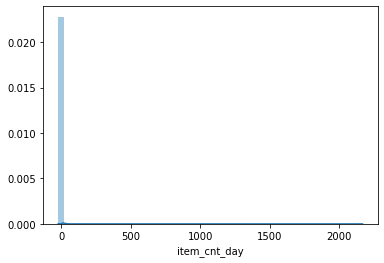

In [6]:
#histogram
sns.distplot(sales['item_cnt_day'])

In [35]:
sales['item_cnt_day'].value_counts(bins=3)

(-24.192, 708.333]     2935847
(708.333, 1438.667]          1
(1438.667, 2169.0]           1
Name: item_cnt_day, dtype: int64

Most values concentrated until ~400. 2 of the values are really extreme. Let's get rid of 'em.

In [4]:
sales = sales[sales['item_cnt_day'] <= 700]

In [37]:
sales['item_cnt_day'].value_counts(bins=2)

(-22.692, 323.5]    2935828
(323.5, 669.0]           19
Name: item_cnt_day, dtype: int64

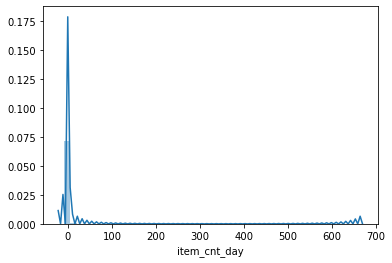

In [38]:
sns.distplot(sales['item_cnt_day'])

In [39]:
print("Skewness: %f" % sales['item_cnt_day'].skew())
print("Kurtosis: %f" % sales['item_cnt_day'].kurt())

Skewness: 100.053652
Kurtosis: 20154.135729


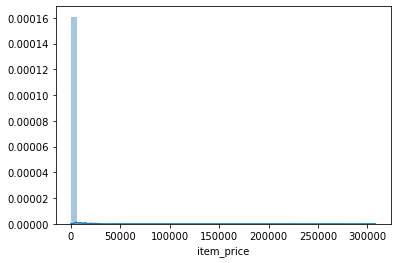

In [42]:
sns.distplot(sales['item_price'])

In [53]:
sales['item_price'].value_counts(bins=10)

(-308.98199999999997, 30797.1]    2935630
(30797.1, 61595.2]                    216
(277181.9, 307980.0]                    1
(61595.2, 92393.3]                      0
(92393.3, 123191.4]                     0
(123191.4, 153989.5]                    0
(153989.5, 184787.6]                    0
(184787.6, 215585.7]                    0
(215585.7, 246383.8]                    0
(246383.8, 277181.9]                    0
Name: item_price, dtype: int64

In [5]:
sales = sales[(sales['item_price'] > 0) & (sales['item_price'] < 51000)]

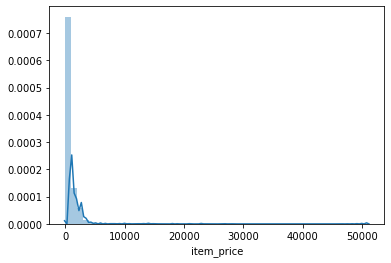

In [55]:
sns.distplot(sales['item_price'])

In [56]:
print("Skewness: %f" % sales['item_price'].skew())
print("Kurtosis: %f" % sales['item_price'].kurt())

Skewness: 8.981222
Kurtosis: 109.247253


(-0.5, 33.5, 0.0, 700.0)

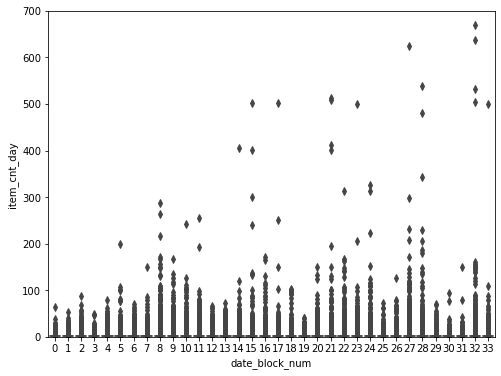

In [9]:
var = 'date_block_num'
data = pd.concat([sales['item_cnt_day'], sales[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='item_cnt_day', data=data)
fig.axis(ymin=0, ymax=700)

See clear increasing trend with time. 

In [ ]:
shopwise_sales

In [17]:
sales=pd.read_hdf("Inputs/Translated_sales_preprocessed.hdf")
sales['item_cnt_day'].describe()

count    3.106983e+06
mean     1.148098e+00
std      2.007730e+00
min     -1.600000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+03
Name: item_cnt_day, dtype: float64